First, from the `yolov3` directory, run this script to convert `.pt` file to `.weights` file:

In [ ]:
> python3  -c "from models import *; convert('cfg/beer-yolov3-spp-v4.cfg', 'weights/best-yolov3-spp-v4.pt')"
> mv converted.weights weights/best-yolov3-spp-v4.weights

# Also for the Tiny-YOLO
> python3  -c "from models import *; convert('cfg/beer-yolov3-tiny.cfg', 'weights/best-yolov3-tiny.pt')"
> mv converted.weights weights/best-yolov3-tiny.weights

Testing tinyYOLO:

Then, to convert them to Keras, run the following script from `keras-yolov3` directory:

In [ ]:
> python3 convert.py \
    ../yolov3/cfg/beer-yolov3-spp-v4.cfg \
    ../yolov3/weights/best-yolov3-spp-v4.weights \
    ../yolov3/weights/best-yolov3-spp-v4.h5

Now, everything is ready to convert the model to `.mlmodel`.

In [1]:
from keras.models import load_model
yolo = load_model('yolov3/weights/yolov3-spp-384.h5')

Using TensorFlow backend.
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/p

/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Vlad/.virtualenvs/yolo/lib/python

/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [2]:

yolo.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 512, 384, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 384, 32) 864         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 384, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 512, 384, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

In [3]:
def draw(img, bboxes, offset_fn_gen):
    blockSize = 32
    boxesPerCell = 3
    numClasses = 6
    anchors = [[116,90,  156,198,  373,326], [30,61,  62,45,  59,119], [10,13,  16,30,  33,23]]

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def exp(x):
        return np.exp(x)

    def _offset(i, ch, cx, cy):
        return output[i][0][cy][cx][ch]


    for i in range(3):

        def offset_fn_gen_keras(bboxes, i):
            def offset(ch, cx, cy):
                return bboxes[i][0][cy][cx][ch]
            return offset

        gridHeight = [16, 32, 64]
        gridWidth = [12, 24, 48]
        
        stride = 512 // max(gridHeight[i], gridWidth[i])
        for cy in range(gridHeight[i]):
            for cx in range(gridWidth[i]):
                for b in range(boxesPerCell):
                    channel = b*(numClasses + 5)

                    tx = offset(channel, cx, cy)
                    ty = offset(channel + 1, cx, cy)
                    tw = offset(channel + 2, cx, cy)
                    th = offset(channel + 3, cx, cy)
                    tc = offset(channel + 4, cx, cy)
                    scale = 2 ** i
                    x = cx + sigmoid(tx)
                    y = cy + sigmoid(ty)

                    w = exp(tw) * anchors[i][2*b    ]
                    h = exp(th) * anchors[i][2*b + 1]

                    x *= stride
                    y *= stride
#                     w *= stride
#                     h *= stride
        
                    confidence = sigmoid(tc)

                    classes = [0] * numClasses
                    for c in range(numClasses):
                        classes[c] = offset(channel + 5 + c, cx, cy)

                    classes = np.array(classes)
                    classes = np.exp(classes)
                    classes /= np.sum(classes)

                    bestClassScore = classes.max()
                    cls = np.argmax(classes)
                    
                    confidenceInClass = bestClassScore * confidence

                    if confidenceInClass > 0.2 and cls in [1, 2, 3]:
                        predictions.append((x - w / 2, y - h/2, x + w / 2, y + h / 2, confidenceInClass))

    predictions = sorted(predictions, key=lambda x:x[-1], reverse=True)
    
    def bb_intersection_over_union(boxA, boxB):
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        # return the intersection over union value
        return iou

    included = [True] * len(predictions)
    for i in range(len(predictions)):
        if not included[i]:
            continue
        for j in range(i + 1, len(predictions)):
            if not included[j]:
                continue
            if bb_intersection_over_union(predictions[i][:4], predictions[j][:4]) > 0.2:
                included[j] = False
    
    preds = []
    for i in range(len(included)):
        if included[i]:
            preds.append(predictions[i])
    
    draw = ImageDraw.Draw(im)
    for pred in preds:
        draw.rectangle(pred[:4], width=2)
    del draw
    return im

In [4]:
def offset_fn_gen_keras(bboxes, i):
    def offset(ch, cx, cy):
        return bboxes[i][0][cy][cx][ch]
    return offset

In [149]:
def offset_fn_gen_pt(bboxes, i):
    def offset(ch, cx, cy):
        div, mod = ch // 11, ch % 11
        return bboxes[i][0][div][cy][cx][mod]
    return offset

In [6]:
from PIL import Image

im = Image.open("/Users/Vlad/CROPPED.png")
draw(im, bboxes, offset_fn_gen_keras)

NameError: name 'bboxes' is not defined

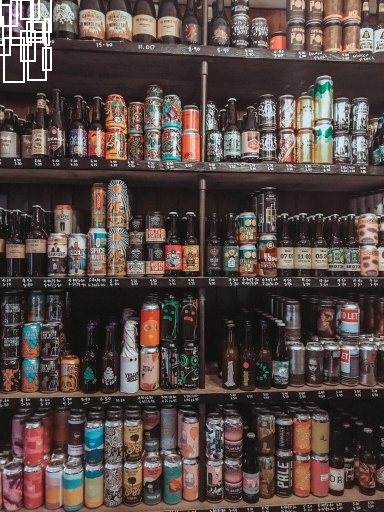

In [163]:
im = Image.open("/Users/Vlad/CROPPED.png")
draw(im, bboxes_pt, offset_fn_gen_pt)

In [ ]:
im = Image.open("/Users/Vlad/CROPPED.png")
draw(im, bboxes_pt, offset_fn_gen_pt)

In [146]:
p = _1

In [152]:
bboxes_pt = [_1, _2, _3]

In [151]:
# _1 = np.load('/Users/Vlad/Downloads/output_0.npy')
# _2 = np.load('/Users/Vlad/Downloads/output_1.npy')
# _3 = np.load('/Users/Vlad/Downloads/output_2.npy')
_1 = np.load('/Users/Vlad/Downloads/output2_0.npy')
_2 = np.load('/Users/Vlad/Downloads/output2_1.npy')
_3 = np.load('/Users/Vlad/Downloads/output2_2.npy')

In [164]:
bboxes_pt[1].shape

(1, 3, 32, 24, 11)

In [166]:
bboxes_pt[0].shape

(1, 3, 16, 12, 11)

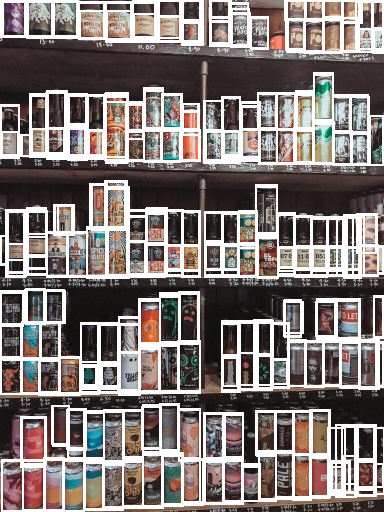

In [175]:
from PIL import Image, ImageDraw

im = Image.open("/Users/Vlad/CROPPED.png")
dr = ImageDraw.Draw(im)
for i in range(3):
    for j in range(len(bboxes_pt[i][0])):
        for k in range(len(bboxes_pt[i][0][j])):
            for q in range(len(bboxes_pt[i][0][j][k])):
                c = bboxes_pt[i][0][j][k][q]
                x, y, w, h = c[:4]
                rect = (x-w/2, y-h/2, x+w/2, y+h/2)
                if c[4] > 0.2:
                    dr.rectangle(rect, width=2)
# for pred in preds:
#     dr.rectangle(pred[:4], width=2)
del dr
im

In [58]:
labels = [
    "bottle",
    "can",
    "case",
    "label",
    "multipack",
    "multiple_case"
]

In [26]:
bboxes[0].sum(), bboxes[1].sum(), bboxes[2].sum()

(-21333.268, -91928.51, -369473.56)

In [54]:
bboxes[0].shape

(1, 16, 12, 33)

In [55]:
bboxes[2].shape

(1, 64, 48, 33)

In [37]:
predictions['output1'].sum(), predictions['output2'].sum(), predictions['output3'].sum()

(-21321.402645111084, -91850.98141050339, -369024.14354264736)

In [22]:
0: -21356.34
1: -92124.586
2: -368874.75

(1, 32, 24, 33)

In [23]:
bboxes[2].shape

(1, 64, 48, 33)

In [4]:
!pip install --upgrade coremltools==3.0

  Using cached coremltools-3.0-cp36-none-macosx_10_15_intel.whl (4.0 MB)
  Attempting uninstall: coremltools
    Found existing installation: coremltools 3.3
    Uninstalling coremltools-3.3:
      Successfully uninstalled coremltools-3.3


In [9]:
%load_ext autoreload
%autoreload 2

In [7]:
import coremltools

coreml_model = coremltools.converters.keras.convert(
    yolo,
    input_names='image',
    image_input_names='image',
    image_scale=1/255.,
    use_float_arraytype=True)

# coreml_model.save('yolov3/coreml/yolov3-spp-512-float.mlmodel')

0 : image, <keras.engine.topology.InputLayer object at 0x145981828>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x145981898>
2 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x145981cc0>
3 : leaky_re_lu_1, <keras.layers.advanced_activations.LeakyReLU object at 0x145981be0>
4 : zero_padding2d_1, <keras.layers.convolutional.ZeroPadding2D object at 0x145981f28>
5 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x145981f60>
6 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x1459a3198>
7 : leaky_re_lu_2, <keras.layers.advanced_activations.LeakyReLU object at 0x1459a32e8>
8 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x1459a3320>
9 : batch_normalization_3, <keras.layers.normalization.BatchNormalization object at 0x1459a34a8>
10 : leaky_re_lu_3, <keras.layers.advanced_activations.LeakyReLU object at 0x1459a35f8>
11 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x1459a3630>
12 

101 : batch_normalization_29, <keras.layers.normalization.BatchNormalization object at 0x1459ca940>
102 : leaky_re_lu_29, <keras.layers.advanced_activations.LeakyReLU object at 0x1459caa90>
103 : add_12, <keras.layers.merge.Add object at 0x1459caac8>
104 : conv2d_30, <keras.layers.convolutional.Conv2D object at 0x1459cab00>
105 : batch_normalization_30, <keras.layers.normalization.BatchNormalization object at 0x1459cac88>
106 : leaky_re_lu_30, <keras.layers.advanced_activations.LeakyReLU object at 0x1459cadd8>
107 : conv2d_31, <keras.layers.convolutional.Conv2D object at 0x1459cae10>
108 : batch_normalization_31, <keras.layers.normalization.BatchNormalization object at 0x1459c3fd0>
109 : leaky_re_lu_31, <keras.layers.advanced_activations.LeakyReLU object at 0x1459d1128>
110 : add_13, <keras.layers.merge.Add object at 0x1459d1160>
111 : conv2d_32, <keras.layers.convolutional.Conv2D object at 0x1459d1198>
112 : batch_normalization_32, <keras.layers.normalization.BatchNormalization object

199 : batch_normalization_56, <keras.layers.normalization.BatchNormalization object at 0x1459f92b0>
200 : leaky_re_lu_56, <keras.layers.advanced_activations.LeakyReLU object at 0x1459f9400>
201 : conv2d_57, <keras.layers.convolutional.Conv2D object at 0x1459f9438>
202 : batch_normalization_57, <keras.layers.normalization.BatchNormalization object at 0x1459f95c0>
203 : leaky_re_lu_57, <keras.layers.advanced_activations.LeakyReLU object at 0x1459f9710>
204 : conv2d_58, <keras.layers.convolutional.Conv2D object at 0x1459f9748>
205 : batch_normalization_58, <keras.layers.normalization.BatchNormalization object at 0x1459f98d0>
206 : leaky_re_lu_58, <keras.layers.advanced_activations.LeakyReLU object at 0x1459f9a20>
207 : conv2d_61, <keras.layers.convolutional.Conv2D object at 0x1459f9a58>
208 : batch_normalization_60, <keras.layers.normalization.BatchNormalization object at 0x1459f9be0>
209 : leaky_re_lu_60, <keras.layers.advanced_activations.LeakyReLU object at 0x1459f9d30>
210 : up_sampli

In [9]:
from coremltools.models.neural_network import quantization_utils
import coremltools

def quantize_model(mlmodel, nbits, method='linear'):
    """Quantize the weights of an mlmodel to a specific number of bits.
    Args:
        mlmodel (coremltools.models.MLModel): A Core ML model
        nbits (int): the bit depth of the quantized weights.
        method (string): the quantization method.
    
    Returns:
        A quantized Core ML Model.
    """
    quantized_model = quantization_utils.quantize_weights(
        mlmodel, nbits, method)
    # If we are on a Mac OS, quantization will return a Model,
    # otherwise it will return just the model spec and we'll need to create one
    if type(quantized_model) == coremltools.models.MLModel:
        return quantized_model
    return coremltools.models.MLModel(quantized_model)

In [12]:
quantized_model = quantize_model(coreml_model, 8)

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Fused conv2d_1->batch_normalization_1
Fused conv2d_2->batch_normalization_2
Fused conv2d_3->batch_normalization_3
Fused conv2d_4->batch_normalization_4
Fused conv2d_5->batch_normalization_5
Fused conv2d_6->batch_normalization_6
Fused conv2d_7->batch_normalization_7
Fused conv2d_8->batch_normalization_8
Fused conv2d_9->batch_normalization_9
Fused conv2d_10->batch_normalization_10
Fused conv2d_11->batch_normalization_11
Fused conv2d_12->batch_normalization_12
Fused conv2d_13->batch_normalization_13
Fused conv2d_14->batch_normalization_14
Fused conv2d_15->batch_normalization_15
Fused conv2d_16->batch_normalization_16
Fused conv2d_17->batch_normalization_17
Fused conv2d_18->batch_normalization_18
Fused conv2d_19->batch_normalization_19
Fused conv2d_20->batch_normalization_20
Fused conv2d_21->batch_normalization_21
Fused conv2d_22->batch_normalization_22
Fused conv2d_23->batch_normalization_23
Fused conv2d_2

In [6]:

coreml_model.save('yolov3/coreml/yolov3-spp-512-float.mlmodel')

In [15]:
quantized_model.save('yolov3/coreml/yolov3-spp-512x384-float-quantized.mlmodel')

In [13]:
print(quantized_model)

input {
  name: "image"
  type {
    imageType {
      width: 384
      height: 512
      colorSpace: RGB
    }
  }
}
output {
  name: "output1"
  type {
    multiArrayType {
      shape: 33
      shape: 16
      shape: 12
      dataType: FLOAT32
    }
  }
}
output {
  name: "output2"
  type {
    multiArrayType {
      shape: 33
      shape: 32
      shape: 24
      dataType: FLOAT32
    }
  }
}
output {
  name: "output3"
  type {
    multiArrayType {
      shape: 33
      shape: 64
      shape: 48
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "coremltoolsVersion"
    value: "3.2"
  }
}



# Testing the model

In [27]:
import coremltools
model = coremltools.models.MLModel('yolov3/coreml/yolov3-spp-384.mlmodel')

In [28]:
spec = coremltools.models.utils.load_spec('yolov3/coreml/yolov3-spp.mlmodel')

In [29]:
# spec = coremltools.models.utils.load_spe÷c(coreml_model_file)
if spec.WhichOneof('Type') == 'neuralNetworkClassifier':
  nn = spec.neuralNetworkClassifier
if spec.WhichOneof('Type') == 'neuralNetwork':
  nn = spec.neuralNetwork  
if spec.WhichOneof('Type') == 'neuralNetworkRegressor':
  nn = spec.neuralNetworkRegressor

preprocessing = nn.preprocessing[0].scaler   #out of range error
print( 'channel scale: ', preprocessing.channelScale)
print( 'blue bias: ', preprocessing.blueBias)
print( 'green bias: ', preprocessing.greenBias)
print( 'red bias: ', preprocessing.redBias)

channel scale:  0.003921568859368563
blue bias:  0.0
green bias:  0.0
red bias:  0.0


(384, 512)


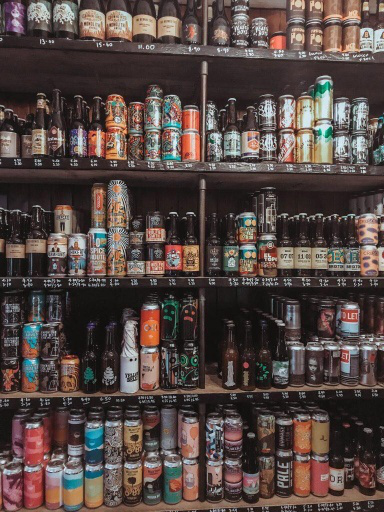

In [48]:
import PIL
img_pil = PIL.Image.fromarray(img)
print(img_pil.size)
img_pil

In [52]:
predictions = coreml_model.predict({'image': img_pil})

In [42]:
predictions['output1'].sum(), predictions['output2'].sum(), predictions['output3'].sum()

(-21321.402645111084, -91850.98141050339, -369024.14354264736)

In [53]:
predictions['output1'].sum(), predictions['output2'].sum(), predictions['output3'].sum()

(-21321.402, -91850.984, -369024.12)

In [33]:
predictions['output1'].shape

(33, 16, 12)

In [10]:
model

input {
  name: "image"
  type {
    imageType {
      width: 416
      height: 416
      colorSpace: RGB
    }
  }
}
output {
  name: "output1"
  type {
    multiArrayType {
      shape: 33
      shape: 13
      shape: 13
      dataType: DOUBLE
    }
  }
}
output {
  name: "output2"
  type {
    multiArrayType {
      shape: 33
      shape: 26
      shape: 26
      dataType: DOUBLE
    }
  }
}
output {
  name: "output3"
  type {
    multiArrayType {
      shape: 33
      shape: 52
      shape: 52
      dataType: DOUBLE
    }
  }
}